## Imports

In [1]:
import pandas as pd
import numpy as np
import openai
from tqdm import tqdm
import json
import re
import random
import csv
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

In [65]:
df = pd.read_json("hf://datasets/FreedomIntelligence/medical-o1-verifiable-problem/medical_o1_verifiable_problem.json")
df.head()

,Open-ended Verifiable Question,Ground-True Answer
0,An 88-year-old woman with osteoarthritis is ex...,Gastric ulcer
1,In the context of disseminated intravascular c...,Fibrin degradation products
2,"In a 3-year-old boy with severe diarrhea, vomi...","Double-stranded, icosahedral, non-enveloped"
3,Based on the chest radiograph and abdominal CT...,Hydatid Cyst
4,What is one potential side effect that is not ...,Anaphylaxis


In [66]:
gpt_results_df = pd.read_csv('/content/drive/MyDrive/MIDS/Datasci 266/266 Final Project/dsft_output/dsft_gpt4o_results.csv')
llama_results_df = pd.read_csv('/content/drive/MyDrive/MIDS/Datasci 266/266 Final Project/dsft_output/dsft_llama_results.csv')
huatuo_p1 = pd.read_csv('/content/drive/MyDrive/MIDS/Datasci 266/266 Final Project/dsft_output/dsft_huatuo_results.csv')
huatuo_p2 = pd.read_csv('/content/drive/MyDrive/MIDS/Datasci 266/266 Final Project/dsft_output/dsft_huatuo_results_56.csv')
huatuo_results_df = pd.concat([huatuo_p1, huatuo_p2], axis = 0)
huatuo_results_df.head()

,Answer,Prompts,post_ft_results
0,"```\n{\n ""response"": [\n {\n ...",['<question>\nAn 88-year-old woman with osteoa...,True
1,"```\n{\n ""thinking"": [\n {\n ""step_id...",['<question>\nIn the context of disseminated i...,True
2,"below.\n\n```json\n{\n ""Inner Thinking"": [\n ...",['<question>\nIn a 3-year-old boy with severe ...,True
3,"</question>\n\n## Thinking\n\nAlright, let's t...",['<question>\nBased on the chest radiograph an...,True
4,"```json\n{\n ""innerThinking"": [\n {\...",['<question>\nWhat is one potential side effec...,True


## Analysis

In [67]:
#!pip install rouge_score

In [68]:
from rouge_score import rouge_scorer

In [69]:
reference = df['Ground-True Answer']

In [70]:
scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)

In [81]:
def add_cols(results_df):

  results_df['num_prompts'] = results_df['Prompts'].apply(lambda x : x.count('\'<question>'))
  results_df["baseline_results"] = (results_df['num_prompts'] == 1).astype(int)
  results_df['post_ft_results'] = results_df['post_ft_results'].astype(bool).astype(int)

  precisions, recalls, f1s = [], [], []

  for ref, cand in zip(reference, results_df['Answer']):

    scores = scorer.score(ref, cand)
    precisions.append(scores['rouge1'].precision)
    recalls.append(scores['rouge1'].recall)
    f1s.append(scores['rouge1'].fmeasure)

  results_df['precision'] = precisions
  results_df['recall'] = recalls
  results_df['f1'] = f1s

  results_df['incorrect reality'] = np.where(results_df['f1'] == 0, 1, 0)

  results_df['incorrect model'] = np.where((results_df['f1'] == 0) & (results_df['post_ft_results'] == 1), 1, 0)

  return results_df

In [82]:
gpt_results_df = add_cols(gpt_results_df)
gpt_results_df.head()

,Answer,Prompts,post_ft_results,num_prompts,baseline_results,precision,recall,f1,incorrect reality,incorrect model
0,ChatCompletion(id='chatcmpl-BzKTuGCf8gFMf7qMgV...,['<question>\nAn 88-year-old woman with osteoa...,1,1,1,0.007143,1.0,0.014184,0,0
1,ChatCompletion(id='chatcmpl-BzKUJD7fdyTOkOg4jK...,['<question>\nAn 88-year-old woman with osteoa...,1,1,1,0.000000,0.0,0.000000,1,1
2,ChatCompletion(id='chatcmpl-BzKUX8iv6ljR3FN9L7...,['<question>\nIn the context of disseminated i...,1,1,1,0.000000,0.0,0.000000,1,1
3,ChatCompletion(id='chatcmpl-BzKV3bzVJuLTtOInWi...,['<question>\nIn a 3-year-old boy with severe ...,1,3,0,0.000000,0.0,0.000000,1,1
4,ChatCompletion(id='chatcmpl-BzKVfukMaqbuefz4Zd...,['<question>\nBased on the chest radiograph an...,0,4,0,0.000000,0.0,0.000000,1,0


In [83]:
llama_results_df = add_cols(llama_results_df)
llama_results_df.head()

,Answer,Prompts,post_ft_results,num_prompts,baseline_results,precision,recall,f1,incorrect reality,incorrect model
0,Here is the response to the question using the...,['<question>\nAn 88-year-old woman with osteoa...,1,1,1,0.000000,0.000000,0.000000,1,1
1,Here is the response to the question using the...,['<question>\nIn the context of disseminated i...,1,1,1,0.018519,0.333333,0.035088,0,0
2,Here is the response to the question using the...,['<question>\nIn a 3-year-old boy with severe ...,1,1,1,0.000000,0.000000,0.000000,1,1
3,Here is the response to the question using the...,['<question>\nBased on the chest radiograph an...,1,1,1,0.000000,0.000000,0.000000,1,1
4,Here is the response to the question using the...,['<question>\nWhat is one potential side effec...,1,1,1,0.000000,0.000000,0.000000,1,1


In [84]:
huatuo_results_df = add_cols(huatuo_results_df)
huatuo_results_df.head()

,Answer,Prompts,post_ft_results,num_prompts,baseline_results,precision,recall,f1,incorrect reality,incorrect model
0,"```\n{\n ""response"": [\n {\n ...",['<question>\nAn 88-year-old woman with osteoa...,1,1,1,0.003130,1.0,0.006240,0,0
1,"```\n{\n ""thinking"": [\n {\n ""step_id...",['<question>\nIn the context of disseminated i...,1,1,1,0.004478,1.0,0.008915,0,0
2,"below.\n\n```json\n{\n ""Inner Thinking"": [\n ...",['<question>\nIn a 3-year-old boy with severe ...,1,1,1,0.004866,0.4,0.009615,0,0
3,"</question>\n\n## Thinking\n\nAlright, let's t...",['<question>\nBased on the chest radiograph an...,1,3,0,0.000000,0.0,0.000000,1,1
4,"```json\n{\n ""innerThinking"": [\n {\...",['<question>\nWhat is one potential side effec...,1,1,1,0.000000,0.0,0.000000,1,1


In [89]:
def calc_metrics(model_name, df):

  baseline_acc = round(sum(df['baseline_results'])/len(df['baseline_results']),2)
  post_ft_acc = round(sum(df['post_ft_results'])/len(df['post_ft_results']),2)
  avg_num_prompts = round(np.mean(df['num_prompts']),2)

  avg_precision = round(np.mean(df['precision']),2)
  avg_recall = round(np.mean(df['recall']),2)
  avg_f1 = round(np.mean(df['f1']),2)

  incorrect_reality = sum(df['incorrect reality'])
  incorrect_model = sum(df['incorrect model'])

  range_precision = (round(max(df['precision']),2), round(min(df['precision']),2))
  range_recall = (round(max(df['recall']),2), round(min(df['recall']),2))
  range_f1 = (round(max(df['f1']),2), round(min(df['f1']),2))

  return [model_name, baseline_acc, post_ft_acc, avg_num_prompts, avg_precision, avg_recall, avg_f1, incorrect_reality, incorrect_model, range_precision, range_recall, range_f1]

In [90]:
results = []
cols = ['Model', 'Baseline Accuracy', 'Post FT Accuracy', 'Avg Prompts', 'Avg Precision', 'Avg Recall', 'Avg F1', 'Incorrect Reality', 'Incorrect Model', 'Precision Range', 'Recall Range', 'F1 Range']

results.append(calc_metrics('gpt4o', gpt_results_df))
results.append(calc_metrics('llama', llama_results_df))
results.append(calc_metrics('huatuo', huatuo_results_df))

results_df = pd.DataFrame(results, columns=cols)
results_df.head()

,Model,Baseline Accuracy,Post FT Accuracy,Avg Prompts,Avg Precision,Avg Recall,Avg F1,Incorrect Reality,Incorrect Model,Precision Range,Recall Range,F1 Range
0,gpt4o,0.58,0.73,2.02,0.00,0.09,0.00,219,159,"(0.08, 0.0)","(1.0, 0.0)","(0.13, 0.0)"
1,llama,1.00,1.00,1.00,0.01,0.16,0.02,193,193,"(0.36, 0.0)","(1.0, 0.0)","(0.36, 0.0)"
2,huatuo,0.79,1.00,1.28,0.00,0.58,0.01,71,71,"(0.09, 0.0)","(1.0, 0.0)","(0.16, 0.0)"


## Confusion Matrices

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

In [95]:
def calc_mtx_metrics(df):

  tp = ((df['post_ft_results'] == 1) & (df['f1'] > 0)).sum()
  fp = ((df['post_ft_results'] == 1) & (df['f1'] == 0)).sum()
  tn = ((df['post_ft_results'] == 0) & (df['f1'] == 0)).sum()
  fn = ((df['post_ft_results'] == 0) & (df['f1'] > 0)).sum()

  return np.array([[tp, fp],
                   [fn, tn]])

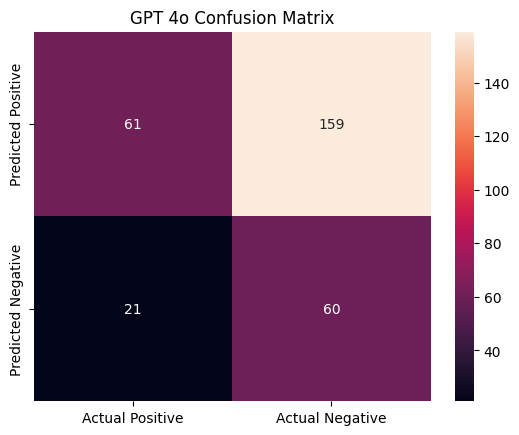

In [98]:
conf_matrix = calc_mtx_metrics(gpt_results_df)

sns.heatmap(conf_matrix, annot=True, fmt='d',
            xticklabels=['Actual Positive', 'Actual Negative'],
            yticklabels=['Predicted Positive', 'Predicted Negative'])
plt.title("GPT 4o Confusion Matrix")
plt.show()

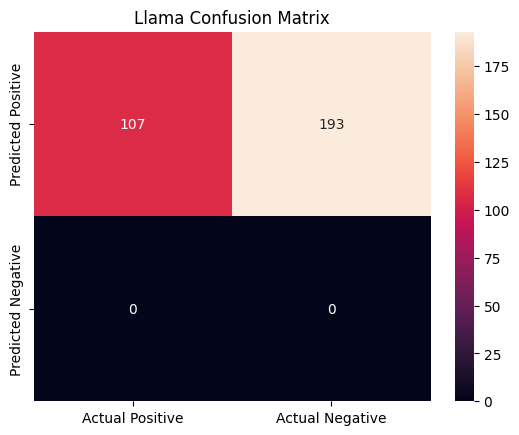

In [99]:
conf_matrix = calc_mtx_metrics(llama_results_df)

sns.heatmap(conf_matrix, annot=True, fmt='d',
            xticklabels=['Actual Positive', 'Actual Negative'],
            yticklabels=['Predicted Positive', 'Predicted Negative'])
plt.title("Llama Confusion Matrix")
plt.show()

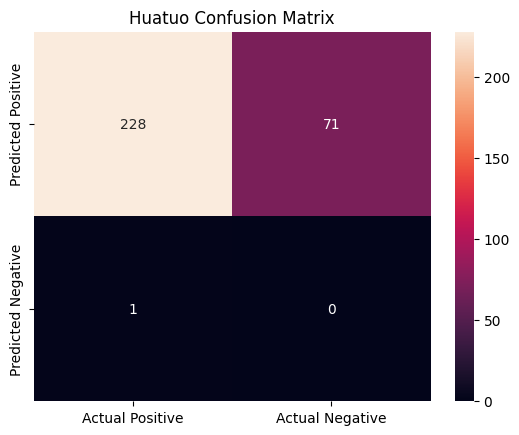

In [100]:
conf_matrix = calc_mtx_metrics(huatuo_results_df)

sns.heatmap(conf_matrix, annot=True, fmt='d',
            xticklabels=['Actual Positive', 'Actual Negative'],
            yticklabels=['Predicted Positive', 'Predicted Negative'])
plt.title("Huatuo Confusion Matrix")
plt.show()